In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"  
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [2]:
train_dataset = load_dataset("yahoo_answers_topics", split="train[:40000]")
validation_dataset = load_dataset("yahoo_answers_topics", split="train[40000:50000]")
test_dataset = load_dataset("yahoo_answers_topics", split="test")
print(train_dataset)
print(validation_dataset)
print(test_dataset)

Found cached dataset yahoo_answers_topics (C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439)
Found cached dataset yahoo_answers_topics (C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439)
Found cached dataset yahoo_answers_topics (C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439)


Dataset({
    features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
    num_rows: 40000
})
Dataset({
    features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
    num_rows: 10000
})
Dataset({
    features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
    num_rows: 60000
})


In [3]:
train_dataset.features

{'id': Value(dtype='int32', id=None),
 'topic': ClassLabel(num_classes=10, names=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government'], id=None),
 'question_title': Value(dtype='string', id=None),
 'question_content': Value(dtype='string', id=None),
 'best_answer': Value(dtype='string', id=None)}

In [4]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['topic']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['topic']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['topic']}, batched=True)

Loading cached processed dataset at C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439\cache-ffe79e45370d2591.arrow
Loading cached processed dataset at C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439\cache-e5c364c11d419d52.arrow
Loading cached processed dataset at C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439\cache-91cebd850a0505cb.arrow


# Model

In [5]:
model_id = 'fabriceyhc/bert-base-uncased-yahoo_answers_topics'

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
            num_labels=train_dataset.features["topic"].num_classes)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [6]:
train_dataset[1]

{'id': 1,
 'topic': 5,
 'question_title': 'What is the best off-road motorcycle trail ?',
 'question_content': 'long-distance trail throughout CA',
 'best_answer': 'i hear that the mojave road is amazing!<br />\\nsearch for it online.',
 'labels': 5}

In [7]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['question_title'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['question_title'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['question_title'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Loading cached processed dataset at C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439\cache-a0eb2dd10d406dc5.arrow
Loading cached processed dataset at C:/Users/researcher/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439\cache-86e5f14f3352df2f.arrow


  0%|          | 0/60 [00:00<?, ?ba/s]

In [8]:
train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

# Train

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
training_args = TrainingArguments(
    output_dir='./topicclassyahooresults',          # output directory
    learning_rate=3e-4,
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, question_content, best_answer, topic, question_title. If id, question_content, best_answer, topic, question_title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 40000
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
Automatic Weights & Biases logging enabled, to disable set os.envi

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.407200,1.437629,0.515700,0.482668,0.687847,0.488479
200,1.337200,1.457278,0.562500,0.554281,0.568966,0.569938
300,1.369000,1.385061,0.584800,0.571223,0.598501,0.578569
400,1.331300,1.398608,0.551300,0.526052,0.618816,0.536394
500,1.303200,1.333625,0.584400,0.587209,0.610982,0.591677
600,1.285400,1.313120,0.574900,0.567905,0.625958,0.559684
700,1.223900,1.292912,0.595400,0.597673,0.610669,0.608283
800,1.181100,1.224201,0.606700,0.609388,0.619230,0.620815
900,1.180100,1.192322,0.611800,0.608132,0.643085,0.603526
1000,1.110500,1.161367,0.628300,0.633318,0.651086,0.624423


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, question_content, best_answer, topic, question_title. If id, question_content, best_answer, topic, question_title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, question_content, best_answer, topic, question_title. If id, question_content, best_answer, topic, question_title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have 

# Confussion matrix

## Validation_dataset

In [11]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, question_content, best_answer, topic, question_title. If id, question_content, best_answer, topic, question_title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 32


In [12]:
preds_output.metrics

{'test_loss': 1.161367416381836,
 'test_accuracy': 0.6283,
 'test_f1': 0.6333177873386159,
 'test_precision': 0.6510862780999652,
 'test_recall': 0.6244228593859814,
 'test_runtime': 56.3536,
 'test_samples_per_second': 177.451,
 'test_steps_per_second': 5.554}

In [13]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

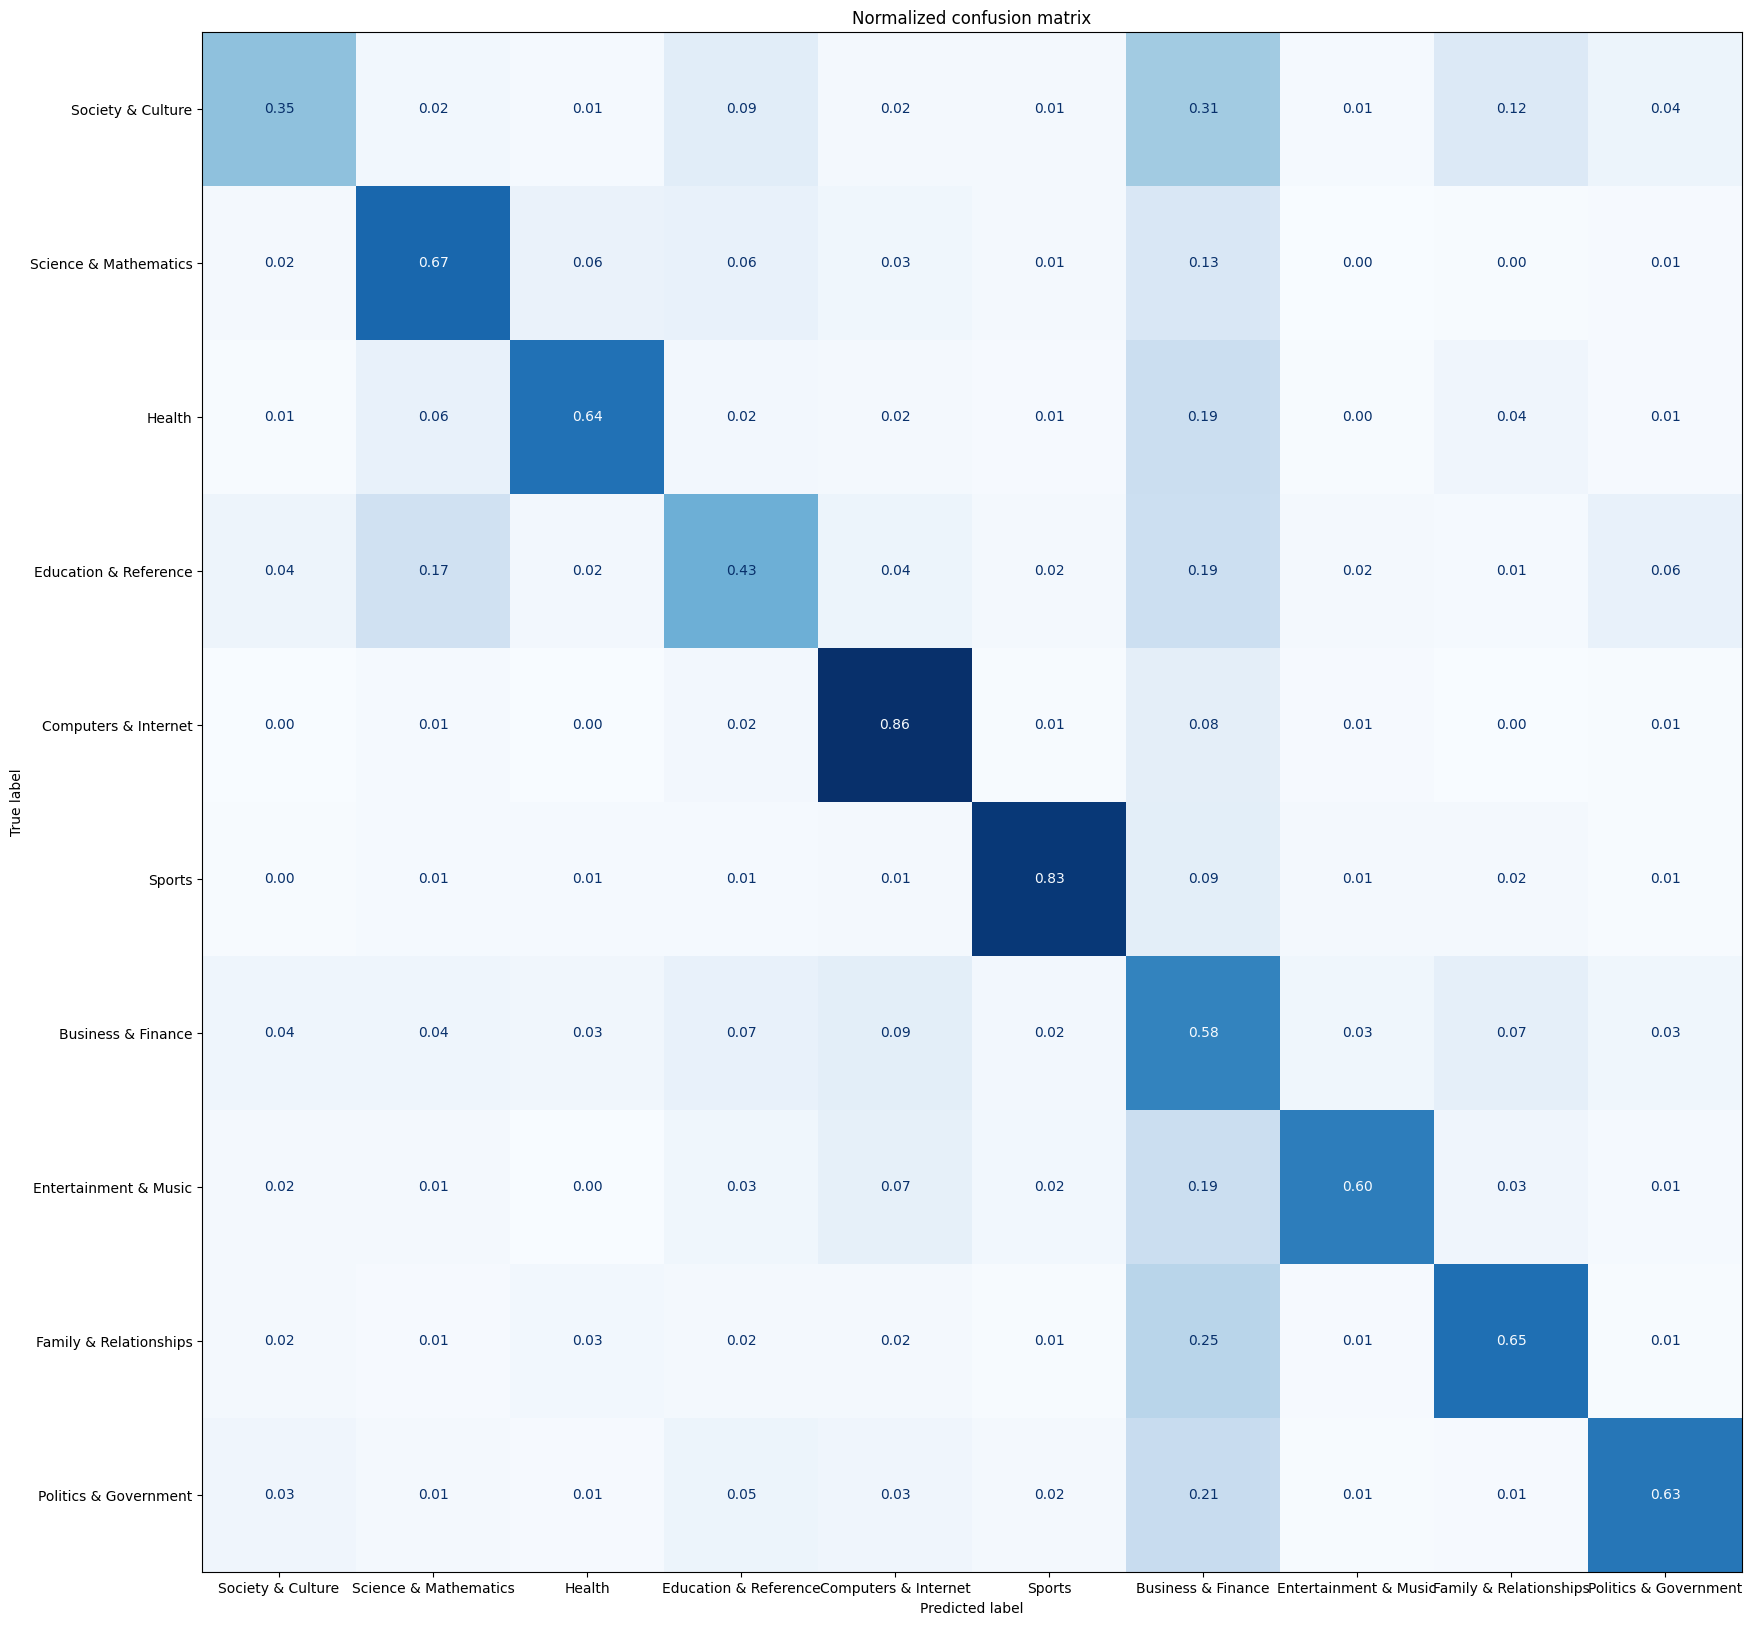

In [15]:
labels = validation_dataset.features["topic"].names

plot_confusion_matrix(y_preds, y_valid, labels)

## Test_dataset_one

In [16]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, question_content, best_answer, topic, question_title. If id, question_content, best_answer, topic, question_title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 60000
  Batch size = 32


In [17]:
preds_output.metrics

{'test_loss': 1.3015176057815552,
 'test_accuracy': 0.6019166666666667,
 'test_f1': 0.6196991186558788,
 'test_precision': 0.6820889274283887,
 'test_recall': 0.6019166666666667,
 'test_runtime': 343.1625,
 'test_samples_per_second': 174.844,
 'test_steps_per_second': 5.464}

In [18]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [19]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

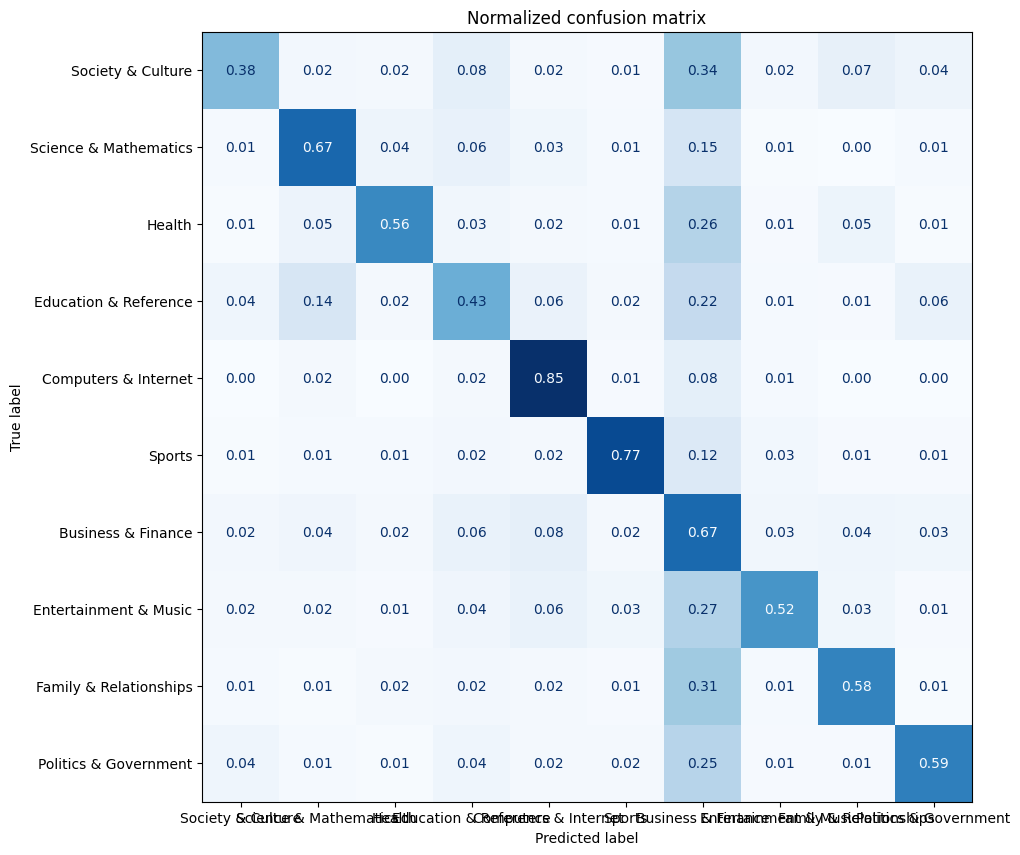

In [20]:
labels = validation_dataset.features["topic"].names

plot_confusion_matrix(y_preds, y_valid, labels)